## Library 

In [332]:
import pandas as pd
import numpy as np
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
import math
import glob
import os
import random
import re
import datatable as dt
import collections
import random

from scipy.interpolate import make_interp_spline, BSpline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

import seaborn as sns
from gensim.models import Word2Vec

from tqdm.notebook import trange, tqdm

from IPython.display import display

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## read csv

In [338]:
data = pd.read_csv('../input/train.csv', parse_dates=['order_date'])
data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## fix seed

In [4]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## year_month feature 만들기

In [85]:
data_2 = data.copy()
data_2['year_month'] = pd.to_datetime(data.order_date).dt.strftime("%Y-%m")
data_2.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12


## 소비자 주문 1건당 total 평균

In [86]:
standard = ['customer_id', 'order_id']
cat = ['total']
total_mean = data_2.groupby(standard).mean().reset_index()[standard + cat]
total_mean.head()

,customer_id,order_id,total
0,12346,491725,74.250
1,12346,491742,37.125
2,12346,491744,37.125
3,12346,492718,37.125
4,12346,492722,1.650


In [89]:
standard = ['customer_id']
order_mean = total_mean.groupby(standard).mean().reset_index()[standard + cat]
order_mean.head(0)

,customer_id,total


In [90]:
order_mean = order_mean.rename({'total':'order_mean'}, axis='columns')
order_mean.head()

,customer_id,order_mean
0,12346,7.020588
1,12347,36.896132
2,12348,91.827664
3,12349,88.432379
4,12350,32.456471


## 소비자 월별 total 평균

In [91]:
standard = ['customer_id', 'year_month']
cat = ['total']
month_mean = data_2.groupby(standard).mean().reset_index()[standard + cat]
month_mean.head()

,customer_id,year_month,total
0,12346,2009-12,37.455000
1,12346,2010-01,-4.455000
2,12346,2010-03,8.926500
3,12346,2010-06,-10.211732
4,12346,2010-10,-4.537500


In [92]:
month_mean = month_mean.rename({'total':'month_mean'}, axis='columns')
month_mean.head()

,customer_id,year_month,month_mean
0,12346,2009-12,37.455000
1,12346,2010-01,-4.455000
2,12346,2010-03,8.926500
3,12346,2010-06,-10.211732
4,12346,2010-10,-4.537500


In [319]:
month_mean.head(10)

,customer_id,year_month,month_mean
0,12346,2009-12,37.455000
1,12346,2010-01,-4.455000
2,12346,2010-03,8.926500
3,12346,2010-06,-10.211732
4,12346,2010-10,-4.537500
5,12346,2011-01,0.000000
6,12347,2010-10,25.225612
7,12347,2010-12,37.885597
8,12347,2011-01,27.048052
9,12347,2011-04,43.742188


## 고객별 이용한 월 수 count

In [325]:
standard = ['customer_id']
cat = ['year_month']
df = month_mean.groupby(standard).count().reset_index()[standard + cat]
df

,customer_id,year_month
0,12346,6
1,12347,7
2,12348,5
3,12349,5
4,12350,1
...,...,...
5909,18283,13
5910,18284,1
5911,18285,1
5912,18286,3


In [329]:
month_count = df.rename({'year_month' : 'month_count'}, axis='columns')
month_count

,customer_id,month_count
0,12346,6
1,12347,7
2,12348,5
3,12349,5
4,12350,1
...,...,...
5909,18283,13
5910,18284,1
5911,18285,1
5912,18286,3


## 제품별 주문 1건당 total 평균

In [93]:
standard = ['product_id', 'order_id']
cat = ['total']
pr_mean = data_2.groupby(standard).mean().reset_index()[standard+cat]
pr_mean.head()

,product_id,order_id,total
0,10002,489437,16.8300
1,10002,490063,1.4025
2,10002,490136,1.4025
3,10002,490140,5.6100
4,10002,490144,16.8300


In [94]:
standard=['product_id']
product_mean = pr_mean.groupby(standard).mean().reset_index()[standard+cat]
product_mean

,product_id,total
0,10002,31.169911
1,10080,7.827029
2,10109,2.772000
3,10120,3.420290
4,10123C,7.363812
...,...,...
4640,PADS,-3.176945
4641,POST,92.120655
4642,SP1002,12.168750
4643,TEST001,22.275000


In [110]:
product_mean = product_mean.rename({'total':'product_mean'}, axis='columns')
product_mean.head(0)

,product_id,product_mean


## 제품별 월별 total 평균

In [111]:
standard = ['product_id', 'year_month']
cat = ['total']
prod_month_mean = data_2.groupby(standard).mean().reset_index()[standard+cat]
prod_month_mean.head()

,product_id,year_month,total
0,10002,2009-12,17.490000
1,10002,2010-01,27.021500
2,10002,2010-02,27.510577
3,10002,2010-03,49.480406
4,10002,2010-04,52.106250


In [112]:
prod_month_mean = prod_month_mean.rename({'total':'prod_month_mean'}, axis='columns')
prod_month_mean

,product_id,year_month,prod_month_mean
0,10002,2009-12,17.490000
1,10002,2010-01,27.021500
2,10002,2010-02,27.510577
3,10002,2010-03,49.480406
4,10002,2010-04,52.106250
...,...,...,...
58852,TEST001,2010-01,37.125000
58853,TEST001,2010-02,0.000000
58854,TEST001,2010-04,37.125000
58855,TEST001,2010-10,-9.281250


## 소비자 제품당 total 평균

In [109]:
standard = ['customer_id', 'product_id']
cat = ['total']
cust_prod_mean = data_2.groupby(standard).mean().reset_index()[standard+cat]
cust_prod_mean.head()

,customer_id,product_id,total
0,12346,15056BL,9.8175
1,12346,15056N,9.8175
2,12346,15056P,9.8175
3,12346,20679,9.8175
4,12346,20682,5.3625


In [113]:
cust_prod_mean = cust_prod_mean.rename({'total':'cust_prod_mean'}, axis='columns')
cust_prod_mean

,customer_id,product_id,cust_prod_mean
0,12346,15056BL,9.8175
1,12346,15056N,9.8175
2,12346,15056P,9.8175
3,12346,20679,9.8175
4,12346,20682,5.3625
...,...,...,...
475438,18287,85041,32.6700
475439,18287,85173,133.8480
475440,18287,85199S,16.6320
475441,18287,85232B,168.3000


## 쇼핑몰 사용 기간 + 사용 기간동안 한 달에 쓴 평균 금액

In [175]:
def all_mean_category(df,year_month):
    df = df.copy()
    first_buy = df.drop_duplicates('customer_id', keep='first')[['order_date','customer_id']].sort_values('customer_id').reset_index(drop=True)
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')

    #지금까지 한달에 평균 얼마씩 썼는지 구하기
    #처음 물건 산 뒤로 몇달 지났는지 계산하여 나눠줌
    first_buy['month']=first_buy['order_date'].map(lambda x: 12 * relativedelta(d, x).years + relativedelta(d, x).months).reset_index(drop=True)
    data_agg_sum = df.groupby('customer_id').sum().reset_index().sort_values('customer_id')
    first_buy['mean'] = data_agg_sum['total']/(first_buy['month']+1)
    first_buy['mean'] = first_buy['mean']
    return first_buy['mean']

In [182]:
use_mall_mean = all_mean_category(data, '2011-11')

In [186]:
use_mall_mean = pd.concat([order_mean['customer_id'],use_mall_mean], axis=1)
use_mall_mean

,customer_id,mean
0,12346,-3.711783
1,12347,596.120885
2,12348,238.000714
3,12349,315.977870
4,12350,61.306667
...,...,...
5909,18283,193.042143
5910,18284,55.424769
5911,18285,33.550000
5912,18286,85.256935


In [187]:
use_mall_mean = use_mall_mean.rename({'mean':'use_mall_mean'}, axis=1)
use_mall_mean.head()

,customer_id,use_mall_mean
0,12346,-3.711783
1,12347,596.120885
2,12348,238.000714
3,12349,315.977870
4,12350,61.306667


## 고객별로 300달러 이상 쓴 달의 수 + 사용 기간으로 나눈 비율 (사용 x)

In [192]:
def count_over(data,year_month):
    df = data.copy()
    
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    cid = 'customer_id'
    cust = df[df['year_month'] < year_month][cid].unique()
    count = pd.DataFrame({'customer_id':cust}).sort_values(cid)
    
    count['count'] = 0
    count = count.set_index(cid)
    while True:
        year_month = date(int(year_month.split('-')[0]),int(year_month.split('-')[1]),1) - dateutil.relativedelta.relativedelta(months=1)
        year_month = year_month.strftime('%Y-%m')
        total = df[df['year_month'] == year_month].groupby('customer_id').sum().reset_index()
        if total.empty: break
        cust = total[total['total']>300][cid].unique()
        for x in cust:
            count.at[x,'count']+=1
    return count.sort_values('customer_id').reset_index()['count']

In [195]:
count_mean = count_over(data, '2011-11')
count_mean

0       0
1       7
2       5
3       3
4       1
       ..
5717    4
5718    1
5719    1
5720    2
5721    5
Name: count, Length: 5722, dtype: int64

In [223]:
data_2[data_2['year_month'] == '2011-11']['customer_id'].unique()

array([17733, 17419, 13461, ..., 14085, 12429, 15444])

## Word2vec

In [22]:
def word2vec_feature(prefix, data_input, groupby, target, size):
    df = data_input.copy()
    
    df_bag = pd.DataFrame(df[[groupby, target]])
    df_bag[target] = df_bag[target].astype(str)
    df_bag[target].fillna('NAN', inplace=True)
    df_bag = df_bag.groupby(groupby, as_index=False)[target].agg({'list' : (lambda x: list(x))}).reset_index()
    doc_list = list(df_bag['list'].values)
    w2v = Word2Vec(doc_list, vector_size=size, window=3, min_count=1, workers=32)
    vocab_keys = list(w2v.wv.key_to_index.keys())
    w2v_array = []
    for v in vocab_keys:
        w2v_array.append(list(w2v.wv[v]))
    df_w2v = pd.DataFrame()
    df_w2v['vocab_keys'] = vocab_keys
    df_w2v = pd.concat([df_w2v, pd.DataFrame(w2v_array)], axis=1)
    df_w2v.columns = [target] + ['w2v_%s_%s_%d'%(groupby,target,x) for x in range(size)]
    print(f'df_w2v: {str(df_w2v.shape)}')
    return df_w2v

In [212]:
word2vec_cust = word2vec_feature("description", data, "customer_id", "description", 50)

df_w2v: (5297, 51)


In [213]:
word2vec_prod = word2vec_feature("description", data, "product_id", "description", 50)

df_w2v: (5297, 51)


In [127]:
word2vec_cust.head()

,description,w2v_customer_id_description_0,w2v_customer_id_description_1,w2v_customer_id_description_2,w2v_customer_id_description_3,w2v_customer_id_description_4,w2v_customer_id_description_5,w2v_customer_id_description_6,w2v_customer_id_description_7,w2v_customer_id_description_8,...,w2v_customer_id_description_20,w2v_customer_id_description_21,w2v_customer_id_description_22,w2v_customer_id_description_23,w2v_customer_id_description_24,w2v_customer_id_description_25,w2v_customer_id_description_26,w2v_customer_id_description_27,w2v_customer_id_description_28,w2v_customer_id_description_29
0,WHITE HANGING HEART T-LIGHT HOLDER,-0.223602,0.252377,1.652200,-0.476249,-0.555245,-0.928931,0.779866,0.293772,-1.031921,...,0.629190,-0.103520,-0.178986,-0.361932,0.811008,-0.616473,-0.677091,0.752721,-1.904581,-1.263390
1,REGENCY CAKESTAND 3 TIER,-0.902743,-0.779785,1.218032,-2.063912,-0.271771,0.154876,0.894163,-0.248419,-0.659425,...,0.626758,1.027821,-0.393478,0.175691,0.680107,0.054346,1.322865,1.175460,-0.471948,-0.513388
2,JUMBO BAG RED RETROSPOT,-0.822661,0.694143,-0.041967,-1.700071,-0.899213,-0.068087,-0.788737,1.363405,-1.416736,...,0.064488,-1.491189,2.101831,1.544185,0.112837,-0.544922,0.967350,0.944593,-1.939502,-0.617667
3,ASSORTED COLOUR BIRD ORNAMENT,0.493050,-0.281652,0.667975,-0.121175,0.301049,-0.244335,1.036459,-0.430067,-1.006371,...,0.205144,0.539324,-0.986662,0.540342,-0.571970,0.062823,0.980306,2.516018,-0.105511,-1.294585
4,PARTY BUNTING,0.188243,0.195057,0.059101,-1.673774,-0.930477,0.884429,-0.090794,1.224192,-0.426525,...,0.944091,-0.607112,-0.032800,-0.703191,-0.739438,0.963348,2.218769,-1.529622,-0.394352,-1.937496


In [128]:
word2vec_prod.head()

,description,w2v_product_id_description_0,w2v_product_id_description_1,w2v_product_id_description_2,w2v_product_id_description_3,w2v_product_id_description_4,w2v_product_id_description_5,w2v_product_id_description_6,w2v_product_id_description_7,w2v_product_id_description_8,...,w2v_product_id_description_20,w2v_product_id_description_21,w2v_product_id_description_22,w2v_product_id_description_23,w2v_product_id_description_24,w2v_product_id_description_25,w2v_product_id_description_26,w2v_product_id_description_27,w2v_product_id_description_28,w2v_product_id_description_29
0,WHITE HANGING HEART T-LIGHT HOLDER,1.850441,-1.983368,1.535650,0.583381,-0.775997,1.133781,1.193888,2.755529,-1.979473,...,1.915878,-2.201639,0.597857,-0.552442,-0.712634,2.333688,1.421136,-0.965329,-1.165313,0.956054
1,REGENCY CAKESTAND 3 TIER,2.419739,-1.946599,2.511571,-0.291092,-0.779740,1.993613,0.658361,0.687247,-0.809062,...,0.476164,-1.214839,1.152451,-0.331355,0.881850,2.125801,0.690118,-3.404049,-0.883339,2.122308
2,JUMBO BAG RED RETROSPOT,0.521126,-1.677412,0.400837,-2.460230,-1.140033,0.106105,-1.739573,1.346120,-1.229302,...,-0.096593,-3.771126,1.441864,-0.179851,-1.705821,2.919240,1.326726,0.677540,-0.059502,-0.263548
3,ASSORTED COLOUR BIRD ORNAMENT,1.067643,-1.564985,0.384159,-0.130788,0.905596,2.002312,-3.657700,1.474389,1.073714,...,-1.292020,-3.134184,2.073195,-0.716304,-0.568640,2.423663,1.016606,-1.170903,0.147691,2.764906
4,PARTY BUNTING,1.620903,-2.211905,2.344223,-0.608887,-0.828714,-0.022363,-0.687619,1.064857,-1.082090,...,2.088797,-2.449510,1.136255,0.519532,-0.723704,2.253003,0.582195,-2.515696,-1.388873,0.567900


In [75]:
train, test, y, features = feature_engineering1(word_pd, '2011-11')

categorical feature: []
x_tr.shape (5501, 94) , x_te.shape (5722, 94)


train.columns

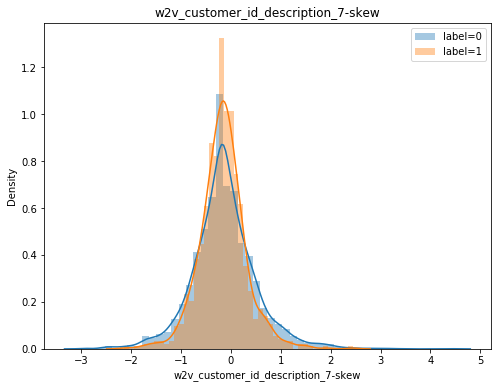

In [83]:
col = 'w2v_customer_id_description_7-skew'
plt.figure(figsize=(8,6))
sns.distplot(train.loc[train['label'] == 0, col], label='label=0')
sns.distplot(train.loc[train['label'] == 1, col], label='label=1')
plt.title(col)
plt.legend()
plt.show()

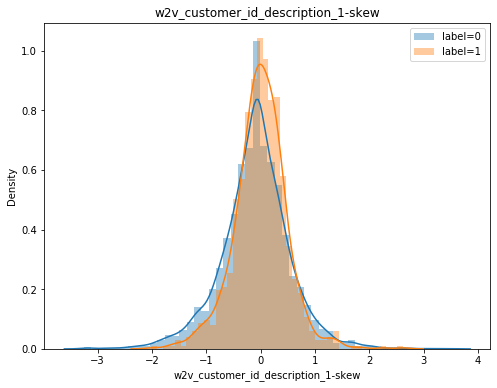

In [82]:
col = 'w2v_customer_id_description_1-skew'
plt.figure(figsize=(8,6))
sns.distplot(train.loc[train['label'] == 0, col], label='label=0')
sns.distplot(train.loc[train['label'] == 1, col], label='label=1')
plt.title(col)
plt.legend()
plt.show()

## Word2Vec Cluster

In [ ]:
kmeans = KMeans(n_clusters=100, random_state=0)
kmeans.fit(word2vec_fe.iloc[:, 2:])

# feature수 늘리기

In [119]:
data_2.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12


In [120]:
cp_data = pd.merge(data_2, train_temp, on='customer_id', how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056


In [121]:
cp_data = pd.merge(cp_data, order_mean, on='customer_id', how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco,order_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056,-98.89075
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056,-98.89075
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056,-98.89075


In [122]:
cp_data = pd.merge(cp_data, month_mean, on=['customer_id','year_month'], how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056,-98.89075,69.604615
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056,-98.89075,69.604615
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056,-98.89075,69.604615


In [123]:
cp_data = pd.merge(cp_data, product_mean, on='product_id', how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,61.686253
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,47.980298
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,41.984250
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,77.655246
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,31.507802


In [124]:
cp_data = pd.merge(cp_data, prod_month_mean, on=['product_id','year_month'], how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean,prod_month_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,61.686253,39.642209
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,47.980298,89.036686
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,41.984250,98.962426
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,77.655246,173.085000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,31.507802,35.823037


In [125]:
cp_data = pd.merge(cp_data, cust_prod_mean, on=['customer_id', 'product_id'], how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,year_month,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,61.686253,39.642209,137.610
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,47.980298,89.036686,103.950
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,41.984250,98.962426,103.950
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,77.655246,173.085000,66.825
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,2009-12,38,0.911228,4037.204056,-98.89075,69.604615,31.507802,35.823037,37.125


In [188]:
cp_data = pd.merge(cp_data, use_mall_mean, on='customer_id', how='left')
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean,use_mall_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,38,0.911228,4037.204056,-98.89075,69.604615,61.686253,39.642209,137.610,104.700391
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,47.980298,89.036686,103.950,104.700391
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,41.984250,98.962426,103.950,104.700391
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,38,0.911228,4037.204056,-98.89075,69.604615,77.655246,173.085000,66.825,104.700391
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,38,0.911228,4037.204056,-98.89075,69.604615,31.507802,35.823037,37.125,104.700391


In [330]:
cp_cp = cp_data.merge(month_count, on='customer_id', how='left')
cp_cp.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean,use_mall_mean,month_count
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,38,0.911228,4037.204056,-98.89075,69.604615,61.686253,39.642209,137.610,104.700391,6
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,47.980298,89.036686,103.950,104.700391,6
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,41.984250,98.962426,103.950,104.700391,6
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,38,0.911228,4037.204056,-98.89075,69.604615,77.655246,173.085000,66.825,104.700391,6
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,38,0.911228,4037.204056,-98.89075,69.604615,31.507802,35.823037,37.125,104.700391,6


In [331]:
cp_cp.to_csv('../input/num_count.csv', index=False)

## numeric한 feature만 저장

In [135]:
cp_data.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,country_freq_enco,country_target_mean_enco,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,38,0.911228,4037.204056,-98.89075,69.604615,61.686253,39.642209,137.610
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,47.980298,89.036686,103.950
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,0.911228,4037.204056,-98.89075,69.604615,41.984250,98.962426,103.950
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,38,0.911228,4037.204056,-98.89075,69.604615,77.655246,173.085000,66.825
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,38,0.911228,4037.204056,-98.89075,69.604615,31.507802,35.823037,37.125


In [189]:
cp_data.to_csv('../input/numeric_mean.csv', index=False)

## word2vec feature 생성

In [333]:
cp_data2 = pd.merge(cp_cp, word2vec_cust, on='description', how='left')
cp_data2.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,...,w2v_customer_id_description_40,w2v_customer_id_description_41,w2v_customer_id_description_42,w2v_customer_id_description_43,w2v_customer_id_description_44,w2v_customer_id_description_45,w2v_customer_id_description_46,w2v_customer_id_description_47,w2v_customer_id_description_48,w2v_customer_id_description_49
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,38,...,-0.733776,-0.171747,-0.830084,0.604663,1.248778,0.343751,1.035154,-0.744649,-0.194745,0.372152
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,...,-0.863754,1.323246,0.426783,1.570976,2.219090,-0.110264,-0.440254,-0.922780,-0.557740,-0.324735
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,...,-0.636732,0.926042,0.115728,1.406372,1.776762,-0.136257,-0.504781,-0.592622,-0.196129,0.174263
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,38,...,-0.518959,-0.116845,-0.182386,-0.097889,1.579158,0.444821,-1.097271,0.083483,-1.105081,0.064172
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,38,...,1.215376,1.439278,0.203853,-0.932696,2.638771,-0.316806,0.024839,-0.948097,-0.121389,0.122130


In [138]:
cp_data2.to_csv('../input/numeric_cust.csv',index=False)

In [215]:
cp_data3 = pd.merge(cp_data, word2vec_prod, on='description', how='left')
cp_data3.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,...,w2v_product_id_description_40,w2v_product_id_description_41,w2v_product_id_description_42,w2v_product_id_description_43,w2v_product_id_description_44,w2v_product_id_description_45,w2v_product_id_description_46,w2v_product_id_description_47,w2v_product_id_description_48,w2v_product_id_description_49
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,38,...,-0.610115,-2.349690,-0.841802,1.807352,-0.580925,0.647276,-1.415110,-0.582757,2.014575,-0.588070
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,...,-0.194282,-0.825003,0.128178,1.298856,-1.426364,0.036244,-2.788139,0.654444,0.150162,-0.370683
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,38,...,-1.067257,-0.957409,-0.003153,2.303638,-1.320197,0.939875,-0.571785,-0.451773,0.211944,0.859522
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,38,...,-0.320920,-1.542237,1.012506,0.857045,-1.455802,-0.017000,-0.692707,0.158625,1.006708,-0.186294
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,38,...,-0.589658,-0.717640,2.057989,0.978114,-1.183474,1.176445,-1.416385,-0.660698,0.621064,-0.838979


In [140]:
cp_data3.to_csv('../input/numeric_prod.csv', index=False)

In [334]:
cp_data4 = pd.merge(cp_data2, word2vec_prod, on='description', how='left')
cp_data4

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,country_label,...,w2v_product_id_description_40,w2v_product_id_description_41,w2v_product_id_description_42,w2v_product_id_description_43,w2v_product_id_description_44,w2v_product_id_description_45,w2v_product_id_description_46,w2v_product_id_description_47,w2v_product_id_description_48,w2v_product_id_description_49
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.6100,38,...,-0.610115,-2.349690,-0.841802,1.807352,-0.580925,0.647276,-1.415110,-0.582757,2.014575,-0.588070
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,38,...,-0.194282,-0.825003,0.128178,1.298856,-1.426364,0.036244,-2.788139,0.654444,0.150162,-0.370683
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.6500,38,...,-1.067257,-0.957409,-0.003153,2.303638,-1.320197,0.939875,-0.571785,-0.451773,0.211944,0.859522
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.3200,38,...,-0.320920,-1.542237,1.012506,0.857045,-1.455802,-0.017000,-0.692707,0.158625,1.006708,-0.186294
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.5000,38,...,-0.589658,-0.717640,2.057989,0.978114,-1.183474,1.176445,-1.416385,-0.660698,0.621064,-0.838979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780497,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,1.4025,15676,United Kingdom,-1.4025,38,...,-1.315471,-1.262935,0.900750,1.517209,-1.248614,0.295264,-1.596313,0.267632,0.658436,0.262897
780498,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,5.4285,15676,United Kingdom,-5.4285,38,...,0.246827,-0.623867,0.707087,1.257065,-1.418684,-0.182330,-0.267678,-0.227181,0.554516,-0.871418
780499,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,2.0625,16717,United Kingdom,-2.0625,38,...,-0.825583,-1.204818,1.069748,2.477868,-0.034638,-0.319575,-1.448262,-0.425221,-0.139585,-0.488268
780500,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,13.1175,16717,United Kingdom,-13.1175,38,...,-0.610115,-2.349690,-0.841802,1.807352,-0.580925,0.647276,-1.415110,-0.582757,2.014575,-0.588070


In [335]:
cp_data4.to_csv('../input/last_feature.csv', index=False)

In [410]:
cp = pd.read_csv('../input/del_country.csv')

,Unnamed: 0,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean,use_mall_mean
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,-98.89075,69.604615,61.686253,39.642209,137.610,104.700391
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,-98.89075,69.604615,47.980298,89.036686,103.950,104.700391
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,-98.89075,69.604615,41.984250,98.962426,103.950,104.700391
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,-98.89075,69.604615,77.655246,173.085000,66.825,104.700391
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,-98.89075,69.604615,31.507802,35.823037,37.125,104.700391


In [413]:
cp = cp.drop(['Unnamed: 0'], axis=1)
cp.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total,order_mean,month_mean,product_mean,prod_month_mean,cust_prod_mean,use_mall_mean
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61,-98.89075,69.604615,61.686253,39.642209,137.610,104.700391
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,-98.89075,69.604615,47.980298,89.036686,103.950,104.700391
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65,-98.89075,69.604615,41.984250,98.962426,103.950,104.700391
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32,-98.89075,69.604615,77.655246,173.085000,66.825,104.700391
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50,-98.89075,69.604615,31.507802,35.823037,37.125,104.700391


In [415]:
cp.to_csv('../input/del_country.csv', index=False)